In [16]:
!pip install transformers datasets captum torch


In [2]:
import pandas as pd
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from captum.attr import IntegratedGradients
from sklearn.metrics import accuracy_score, f1_score


In [15]:
# Load the dataset
df = pd.read_csv('/content/Sentences_with_Strong_Sentiment_Words (1).csv')

# Preview the dataset
print(df.head())


     Word Sentiment                                           Sentence
0  accuse   Negatif  accuse is early and leads to disorders consequ...
1  accuse   Negatif  accuse is there and leads to corpse consequences.
2  accuse   Negatif   accuse is when and leads to insult consequences.
3  accuse   Negatif  accuse is on this note and leads to hunger con...
4  accuse   Negatif     accuse is well and leads to mess consequences.


In [5]:
#Put the Sentences into format for BERT
START_TOKEN = '[TARGET]'
END_TOKEN = '[/TARGET]'

def mark_target_word(row):
    sentence = row['Sentence']
    word = row['Word']
    import re
    pattern = re.compile(re.escape(word), re.IGNORECASE)
    marked_sentence = pattern.sub(f"{START_TOKEN} {word} {END_TOKEN}", sentence, count=1)
    return marked_sentence

df['Marked_Sentence'] = df.apply(mark_target_word, axis=1)


In [6]:
label_list = ['Negatif', 'Positif', 'Neutral']
label_map = {label: idx for idx, label in enumerate(label_list)}
df['Sentiment_Label'] = df['Sentiment'].map(label_map)


In [7]:
#Use the pretrained Tokinizer

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
def tokenize_data(row):
    encoding = tokenizer(
        row['Marked_Sentence'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    encoding = {key: val.squeeze() for key, val in encoding.items()}
    encoding['labels'] = torch.tensor(row['Sentiment_Label'])
    return encoding


In [9]:
dataset = Dataset.from_pandas(df)
tokenized_dataset = dataset.map(tokenize_data, remove_columns=dataset.column_names)
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_list))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted')
    }


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [14]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.040813,0.993506,0.990280


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.040813,0.993506,0.990280
2,No log,0.036666,0.993506,0.990280


TrainOutput(global_step=308, training_loss=0.12941361712170885, metrics={'train_runtime': 3741.3124, 'train_samples_per_second': 0.659, 'train_steps_per_second': 0.082, 'total_flos': 162077865320448.0, 'train_loss': 0.12941361712170885, 'epoch': 2.0})

TrainOutput(global_step=308, training_loss=0.12941361712170885, metrics={'train_runtime': 3741.3124, 'train_samples_per_second': 0.659, 'train_steps_per_second': 0.082, 'total_flos': 162077865320448.0, 'train_loss': 0.12941361712170885, 'epoch': 2.0})

In [17]:
results = trainer.evaluate()
print("Evaluation Results:", results)


Evaluation Results: {'eval_loss': 0.03666594624519348, 'eval_accuracy': 0.9935064935064936, 'eval_f1': 0.9902801600914807, 'eval_runtime': 118.5414, 'eval_samples_per_second': 2.598, 'eval_steps_per_second': 0.329, 'epoch': 2.0}


In [19]:
# Save the fine-tuned model
trainer.save_model('fine_tuned_bert')

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('fine_tuned_bert')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



In [23]:
def explain_prediction(sentence, target_label):
    # Tokenize the input
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding='max_length'
    ).to(device)

    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Get embeddings
    embeddings = model.bert.embeddings(input_ids)
    # embeddings shape: (batch_size, seq_length, embedding_dim)

    # Define a custom forward function that accepts inputs_embeds
    def custom_forward(inputs_embeds):
        outputs = model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        return outputs.logits

    # Initialize Integrated Gradients with the custom forward function
    ig = IntegratedGradients(custom_forward)

    # Compute attributions
    attributions, delta = ig.attribute(
        embeddings,
        target=target_label,
        return_convergence_delta=True
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    attributions_sum = attributions.sum(dim=-1).squeeze(0)
    attributions_norm = attributions_sum / torch.norm(attributions_sum)

    # Print tokens with attributions
    for token, score in zip(tokens, attributions_norm):
        print(f"{token}: {score.item():.4f}")


Now For XAI on the Sentiment of the word based on Surrounding Context

In [24]:
sample_sentence = "The product was [TARGET] amazing [/TARGET] and exceeded expectations."
target_label = label_map['Positif']  # Adjust as per your label mapping

explain_prediction(sample_sentence, target_label)


[CLS]: -0.0029
the: 0.0247
product: 0.0121
was: 0.0215
[: -0.0233
target: -0.0167
]: -0.0156
amazing: -0.0009
[: -0.0062
/: -0.0307
target: -0.0262
]: -0.0423
and: -0.0113
exceeded: -0.0106
expectations: -0.0743
.: 0.0215
[SEP]: 0.9940
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0.0000
[PAD]: 0

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LinearSegmentedColormap

def explain_prediction_heatmap(sentence, target_label):
    # Tokenize the input
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding='max_length'
    ).to(device)

    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Get embeddings
    embeddings = model.bert.embeddings(input_ids)

    # Define a custom forward function
    def custom_forward(inputs_embeds):
        outputs = model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        return torch.softmax(outputs.logits, dim=-1)

    # Initialize Integrated Gradients
    ig = IntegratedGradients(custom_forward)

    # Compute attributions
    attributions, delta = ig.attribute(
        embeddings,
        target=target_label,
        return_convergence_delta=True
    )

    # Get the model's predicted label
    outputs = model(
        inputs_embeds=embeddings,
        attention_mask=attention_mask
    )
    logits = outputs.logits
    predicted_label_idx = torch.argmax(logits, dim=-1).item()
    predicted_label = label_list[predicted_label_idx]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Convert attributions to numpy array
    attributions = attributions.detach().cpu().numpy()[0]

    # Sum attributions across embedding dimensions
    attributions_sum = attributions.sum(axis=1)

    # Filter out special tokens and corresponding attributions
    filtered_tokens = []
    filtered_attributions = []
    for token, attribution, mask in zip(tokens, attributions_sum, attention_mask[0]):
        if mask.item() == 1 and token not in ['[CLS]', '[SEP]', '[PAD]']:
            filtered_tokens.append(token)
            filtered_attributions.append(attribution)

    # Normalize attributions
    attributions_norm = np.array(filtered_attributions)
    norm_val = np.linalg.norm(attributions_norm) + 1e-10
    attributions_norm = attributions_norm / norm_val

    # Create a custom colormap from blue to yellow
    cmap = LinearSegmentedColormap.from_list('BlueToYellow', ['blue', 'yellow'])
    norm = plt.Normalize(vmin=min(attributions_norm), vmax=max(attributions_norm))
    colors = [cmap(norm(val)) for val in attributions_norm]

    # Create the figure and axes for vertical bars
    fig, ax = plt.subplots(figsize=(12, 2))

    # Plot vertical bars
    ax.bar(range(len(filtered_tokens)), attributions_norm, color=colors, align='center')
    ax.set_xticks(range(len(filtered_tokens)))
    ax.set_xticklabels(filtered_tokens, rotation='vertical')
    ax.set_yticks([])

    # Add the predicted label to the title
    ax.set_title(f"Attributions for Predicted Label: {predicted_label}")

    # Add colorbar on the side
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05, label='Attribution Score')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


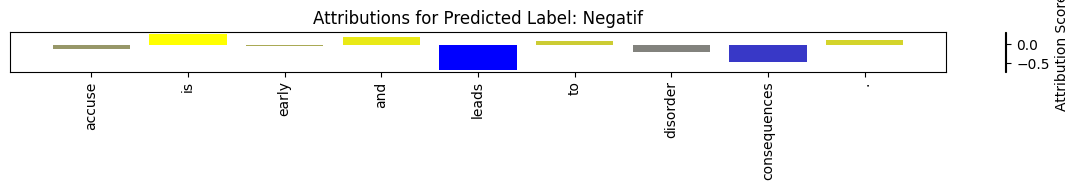

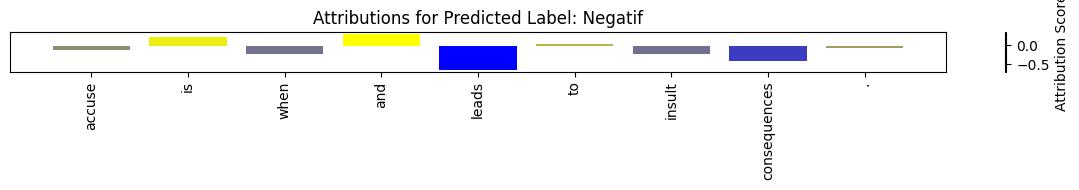

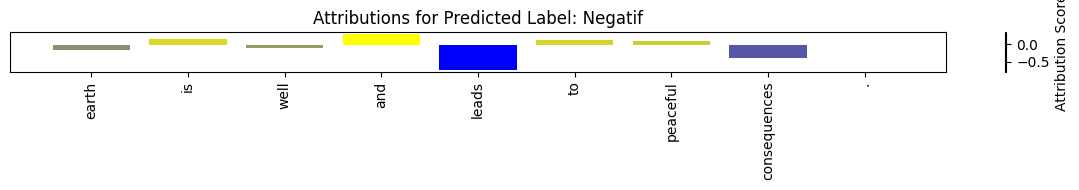

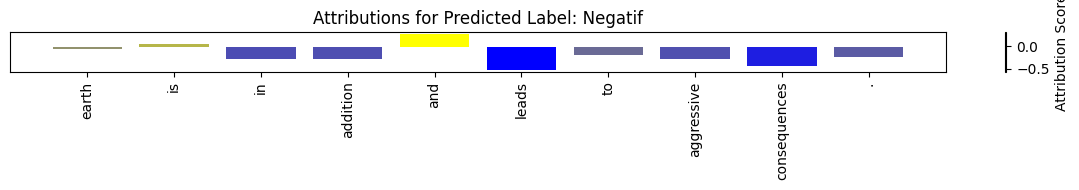

In [35]:
sample_sentences = [
    "Accuse is early and leads to disorder consequences.",
    "Accuse is when and leads to insult consequences.",
    "Earth is well and leads to peaceful consequences.",
    "Earth is in addition and leads to aggressive consequences."
]

for sentence in sample_sentences:
    target_label = label_map['Positif']
    explain_prediction_heatmap(sentence, target_label)
